In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams["figure.figsize"] = (12, 9) # (w, h)

In [2]:
# read csv file
ecg100full = pd.read_csv('../dataset/from_physionet/100full.csv', sep=',', header=None)

# from dataframe to numpy array
ecg100full = ecg100full.iloc[:][0].values

# segment of ecg
signal = ecg100full[:3000]

In [3]:
####### test utils towards C code functions ######

import numpy as np
import utils as utils
from tools import *
import toolstoC as ttc

np.prod(find_extrema(signal, mode='max')[0] == ttc.find_extrema(signal, mode='max')[0]) # 1 means true


1

In [4]:
import numpy as np
import utils as utils

aux = np.asarray([1, 2, -3, 0, 3])
extrema = utils.v_gtzero(aux,len(aux)) + 1
print(extrema)

aux = np.asarray([1, 2, -3, 0, 3])
extrema_true = np.nonzero(aux > 0)[0] + 1
print(extrema_true)

np.prod(extrema == extrema_true) # 1 means true

[1 2 5]
[1 2 5]


1

In [5]:
np.argmax(aux)

4

In [6]:
def hamilton_segmenter(signal=None, sampling_rate=1000.):
    """ECG R-peak segmentation algorithm.

    Follows the approach by Hamilton [Hami02]_.

    Parameters
    ----------
    signal : array
        Input filtered ECG signal.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).

    Returns
    -------
    rpeaks : array
        R-peak location indices.

    References
    ----------
    .. [Hami02] P.S. Hamilton, "Open Source ECG Analysis Software
       Documentation", E.P.Limited, 2002

    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    sampling_rate = float(sampling_rate)
    length = len(signal)
    dur = length / sampling_rate

    # algorithm parameters
    v1s = int(1. * sampling_rate)
    v100ms = int(0.1 * sampling_rate)
    TH_elapsed = np.ceil(0.36 * sampling_rate)
    sm_size = int(0.08 * sampling_rate)
    init_ecg = 8  # seconds for initialization
    if dur < init_ecg:
        init_ecg = int(dur)

    # filtering
    filtered, _, _ = filter_signal(signal=signal,
                                      ftype='butter',
                                      band='lowpass',
                                      order=4,
                                      frequency=25.,
                                      sampling_rate=sampling_rate)
    filtered, _, _ = filter_signal(signal=filtered,
                                      ftype='butter',
                                      band='highpass',
                                      order=4,
                                      frequency=3.,
                                      sampling_rate=sampling_rate)

    # diff
    dx_tmp = utils.diff(filtered, len(filtered))
    dx = utils.v_abs(dx_tmp * sampling_rate, len(dx_tmp)) # tick to C $

    # smoothing
    dx, _ = smoother(signal=dx, kernel='hamming', size=sm_size, mirror=True)

    # buffers
    qrspeakbuffer = np.zeros(init_ecg)
    noisepeakbuffer = np.zeros(init_ecg)
    peak_idx_test = np.zeros(init_ecg)
    noise_idx = np.zeros(init_ecg)
    rrinterval = sampling_rate * np.ones(init_ecg)

    a, b = 0, v1s
    all_peaks, _ = ttc.find_extrema(signal=dx, mode='max')
    for i in range(init_ecg):
        peaks, values = ttc.find_extrema(signal=dx[a:b], mode='max')
        try:
            ind = np.argmax(values)
        except ValueError:
            pass
        else:
            # peak amplitude
            qrspeakbuffer[i] = values[ind]
            # peak location
            peak_idx_test[i] = peaks[ind] + a

        a += v1s
        b += v1s

    # thresholds
    ANP = np.median(noisepeakbuffer)
    AQRSP = np.median(qrspeakbuffer)
    TH = 0.475
    DT = ANP + TH * (AQRSP - ANP)
    DT_vec = []
    indexqrs = 0
    indexnoise = 0
    indexrr = 0
    npeaks = 0
    offset = 0

    beats = []

    # detection rules
    # 1 - ignore all peaks that precede or follow larger peaks by less than 200ms
    lim = int(np.ceil(0.2 * sampling_rate))
    diff_nr = int(np.ceil(0.045 * sampling_rate))
    bpsi, bpe = offset, 0

    for f in all_peaks:
        DT_vec += [DT]
        # 1 - Checking if f-peak is larger than any peak following or preceding it by less than 200 ms
        peak_cond = np.array((all_peaks > f - lim) * (all_peaks < f + lim) * (all_peaks != f))
        peaks_within = all_peaks[peak_cond]
        if peaks_within.any() and (max(dx[peaks_within]) > dx[f]):
            continue

        # 4 - If the peak is larger than the detection threshold call it a QRS complex, otherwise call it noise
        if dx[f] > DT:
            # 2 - look for both positive and negative slopes in raw signal
            if f < diff_nr:
                diff_now = np.diff(signal[0:f + diff_nr])
            elif f + diff_nr >= len(signal):
                diff_now = np.diff(signal[f - diff_nr:len(dx)])
            else:
                diff_now = np.diff(signal[f - diff_nr:f + diff_nr])
            diff_signer = diff_now[diff_now > 0]
            if len(diff_signer) == 0 or len(diff_signer) == len(diff_now):
                continue
            # RR INTERVALS
            if npeaks > 0:
                # 3 - in here we check point 3 of the Hamilton paper
                # that is, we check whether our current peak is a valid R-peak.
                prev_rpeak = beats[npeaks - 1]

                elapsed = f - prev_rpeak
                # if the previous peak was within 360 ms interval
                if elapsed < TH_elapsed:
                    # check current and previous slopes
                    if prev_rpeak < diff_nr:
                        diff_prev = np.diff(signal[0:prev_rpeak + diff_nr])
                    elif prev_rpeak + diff_nr >= len(signal):
                        diff_prev = np.diff(signal[prev_rpeak - diff_nr:len(dx)])
                    else:
                        diff_prev = np.diff(signal[prev_rpeak - diff_nr:prev_rpeak + diff_nr])

                    slope_now = max(diff_now)
                    slope_prev = max(diff_prev)

                    if (slope_now < 0.5 * slope_prev):
                        # if current slope is smaller than half the previous one, then it is a T-wave
                        continue
                if dx[f] < 3. * np.median(qrspeakbuffer):  # avoid retarded noise peaks
                    beats += [int(f) + bpsi]
                else:
                    continue

                if bpe == 0:
                    rrinterval[indexrr] = beats[npeaks] - beats[npeaks - 1]
                    indexrr += 1
                    if indexrr == init_ecg:
                        indexrr = 0
                else:
                    if beats[npeaks] > beats[bpe - 1] + v100ms:
                        rrinterval[indexrr] = beats[npeaks] - beats[npeaks - 1]
                        indexrr += 1
                        if indexrr == init_ecg:
                            indexrr = 0

            elif dx[f] < 3. * np.median(qrspeakbuffer):
                beats += [int(f) + bpsi]
            else:
                continue

            npeaks += 1
            qrspeakbuffer[indexqrs] = dx[f]
            peak_idx_test[indexqrs] = f
            indexqrs += 1
            if indexqrs == init_ecg:
                indexqrs = 0
        if dx[f] <= DT:
            # 4 - not valid
            # 5 - If no QRS has been detected within 1.5 R-to-R intervals,
            # there was a peak that was larger than half the detection threshold,
            # and the peak followed the preceding detection by at least 360 ms,
            # classify that peak as a QRS complex
            tf = f + bpsi
            # RR interval median
            RRM = np.median(rrinterval)  # initial values are good?

            if len(beats) >= 2:
                elapsed = tf - beats[npeaks - 1]

                if elapsed >= 1.5 * RRM and elapsed > TH_elapsed:
                    if dx[f] > 0.5 * DT:
                        beats += [int(f) + offset]
                        # RR INTERVALS
                        if npeaks > 0:
                            rrinterval[indexrr] = beats[npeaks] - beats[npeaks - 1]
                            indexrr += 1
                            if indexrr == init_ecg:
                                indexrr = 0
                        npeaks += 1
                        qrspeakbuffer[indexqrs] = dx[f]
                        peak_idx_test[indexqrs] = f
                        indexqrs += 1
                        if indexqrs == init_ecg:
                            indexqrs = 0
                else:
                    noisepeakbuffer[indexnoise] = dx[f]
                    noise_idx[indexnoise] = f
                    indexnoise += 1
                    if indexnoise == init_ecg:
                        indexnoise = 0
            else:
                noisepeakbuffer[indexnoise] = dx[f]
                noise_idx[indexnoise] = f
                indexnoise += 1
                if indexnoise == init_ecg:
                    indexnoise = 0

        # Update Detection Threshold
        ANP = np.median(noisepeakbuffer)
        AQRSP = np.median(qrspeakbuffer)
        DT = ANP + 0.475 * (AQRSP - ANP)

    beats = np.array(beats)

    r_beats = []
    thres_ch = 0.85
    adjacency = 0.05 * sampling_rate
    for i in beats:
        error = [False, False]
        if i - lim < 0:
            window = signal[0:i + lim]
            add = 0
        elif i + lim >= length:
            window = signal[i - lim:length]
            add = i - lim
        else:
            window = signal[i - lim:i + lim]
            add = i - lim
        # meanval = np.mean(window)
        w_peaks, _ = ttc.find_extrema(signal=window, mode='max')
        w_negpeaks, _ = ttc.find_extrema(signal=window, mode='min')
        zerdiffs = np.where(np.diff(window) == 0)[0]
        w_peaks = np.concatenate((w_peaks, zerdiffs))
        w_negpeaks = np.concatenate((w_negpeaks, zerdiffs))

        pospeaks = sorted(zip(window[w_peaks], w_peaks), reverse=True)
        negpeaks = sorted(zip(window[w_negpeaks], w_negpeaks))

        try:
            twopeaks = [pospeaks[0]]
        except IndexError:
            twopeaks = []
        try:
            twonegpeaks = [negpeaks[0]]
        except IndexError:
            twonegpeaks = []

        # getting positive peaks
        for i in range(len(pospeaks) - 1):
            if abs(pospeaks[0][1] - pospeaks[i + 1][1]) > adjacency:
                twopeaks.append(pospeaks[i + 1])
                break
        try:
            posdiv = abs(twopeaks[0][0] - twopeaks[1][0])
        except IndexError:
            error[0] = True

        # getting negative peaks
        for i in range(len(negpeaks) - 1):
            if abs(negpeaks[0][1] - negpeaks[i + 1][1]) > adjacency:
                twonegpeaks.append(negpeaks[i + 1])
                break
        try:
            negdiv = abs(twonegpeaks[0][0] - twonegpeaks[1][0])
        except IndexError:
            error[1] = True

        # choosing type of R-peak
        n_errors = sum(error)
        try:
            if not n_errors:
                if posdiv > thres_ch * negdiv:
                    # pos noerr
                    r_beats.append(twopeaks[0][1] + add)
                else:
                    # neg noerr
                    r_beats.append(twonegpeaks[0][1] + add)
            elif n_errors == 2:
                if abs(twopeaks[0][1]) > abs(twonegpeaks[0][1]):
                    # pos allerr
                    r_beats.append(twopeaks[0][1] + add)
                else:
                    # neg allerr
                    r_beats.append(twonegpeaks[0][1] + add)
            elif error[0]:
                # pos poserr
                r_beats.append(twopeaks[0][1] + add)
            else:
                # neg negerr
                r_beats.append(twonegpeaks[0][1] + add)
        except IndexError:
            continue

    rpeaks = sorted(list(set(r_beats)))
    rpeaks = np.array(rpeaks, dtype='int')

    return utils.ReturnTuple((rpeaks,), ('rpeaks',))


In [7]:
import numpy as np
import utils
from tools import *

r_peak_loc = hamilton_segmenter(signal, sampling_rate=200)

C:\Users\xiayi\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


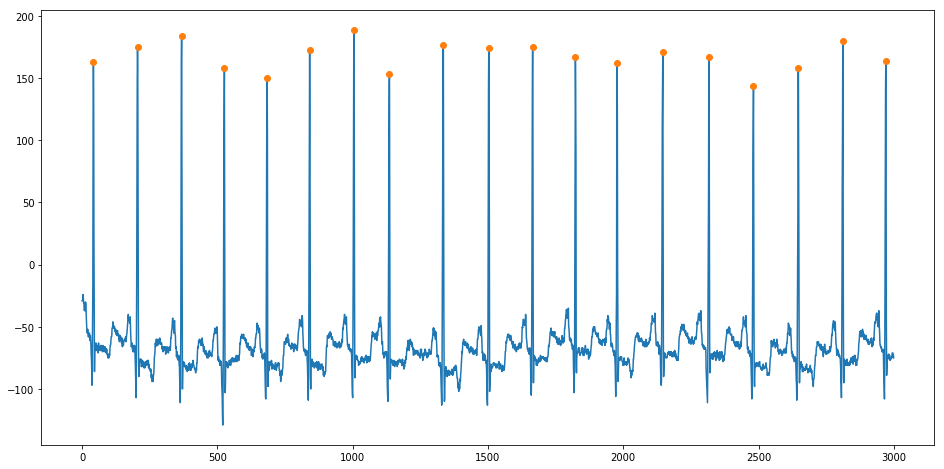

In [8]:
width = 16
height = 8
plt.figure(figsize=(width, height))
plt.plot(signal)
plt.plot(r_peak_loc[0][:],signal[r_peak_loc], 'o')
plt.show()

In [9]:
r_peak_loc_true= np.asarray([42,  205,  368,  526,  683,  841, 1005, 1136, 1335, 1503, 1665, 1823, 1977, 2146, 2316, 2481, 2647, 2811, 2970])

r_peak_loc[0][:] == r_peak_loc_true

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])